# 一、开始
之前了解到了决策树的三种算法，ID3、C4.5、CART，以及随机森林的抽样原理，并且在最后使用泰坦尼克号的数据进行了决策树的预测，本期，继续加深这块儿的学习。

本期的内容是随机森林在实际业务中的案例应用，即利用随机森林构造信用卡违约率识别模型。

1. 创建各种分类器，包括已经掌握的 SVM、决策树、KNN 分类器，以及随机森林分类器；
2. 掌握 GridSearchCV 工具，优化算法模型的参数；
3. 使用 Pipeline 管道机制进行流水线作业。因为在做分类之前，我们还需要一些准备过程，比如数据规范化，或者数据降维等。


# 二、模型参数调优

在开始之前，有一个问题，对于分类算法而言，我们经常需要调节构造过程中的参数，比如决策树、随机森林构造过程中的树节点深度，随机森林的决策树数量，叶节点的最大样本量等等，做这些的目的是为了得到更好的分类结果，但是一个分类算法经常会有多个参数，取值范围也非常广，该如何确定最优参数呢？

这里就有一个模块， GridSearchCV，它是 Python 的参数自动搜索模块，我们只要告诉它想要调优的参数有哪些以及参数的取值范围，它就会把所有的情况都跑一遍，然后告诉我们哪个参数是最优的，结果如何。即将输入的所有参数组合尝试一遍，找到最好的参数。



In [5]:
# 引入GridSearchCV模块
from sklearn.model_selection import GridSearchCV
help(GridSearchCV) #查看参数

Help on class GridSearchCV in module sklearn.model_selection._search:

class GridSearchCV(BaseSearchCV)
 |  GridSearchCV(estimator, param_grid, scoring=None, fit_params=None, n_jobs=None, iid='warn', refit=True, cv='warn', verbose=0, pre_dispatch='2*n_jobs', error_score='raise-deprecating', return_train_score='warn')
 |  
 |  Exhaustive search over specified parameter values for an estimator.
 |  
 |  Important members are fit, predict.
 |  
 |  GridSearchCV implements a "fit" and a "score" method.
 |  It also implements "predict", "predict_proba", "decision_function",
 |  "transform" and "inverse_transform" if they are implemented in the
 |  estimator used.
 |  
 |  The parameters of the estimator used to apply these methods are optimized
 |  by cross-validated grid-search over a parameter grid.
 |  
 |  Read more in the :ref:`User Guide <grid_search>`.
 |  
 |  Parameters
 |  ----------
 |  estimator : estimator object.
 |      This is assumed to implement the scikit-learn estimator 

NameError: name 'estimator' is not defined

四个主要的参数

- estimator #构造的分类器类型名称，
- param_grid #想要优化的参数及取值，以字典或者列表的形式
- cv #交叉验正的折数，
- scoring #准确度的评价标准，默认为None，是score函数，也该一改为accuray，f1等

接下来进行一次案例使用，使用sklearn自带的IRIS数据集，使用随机森林对IRIS进行分类，随机森林的一个重要参数n_estimators代表随机森林生成的决策树的个数，理论上是越多越好，但是要考虑到性能，所以要设置一个合适的值，这里使用GridSearchCV模块来进行搜索合适值。

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_iris  #加载iris数据集

#构造随机森林分类器
rf = RandomForestClassifier()

#构造GirdSearchCV模块参数n_estimators范围为1-11
param = {'n_estimators':range(1,11)}

#加载iris数据集
iris = load_iris()

#进行参数调优
clf = GridSearchCV(estimator=rf,param_grid=param,cv=4)

clf.fit(iris.data,iris.target)

print('最优成绩:%.4lf'%clf.best_score_)
print('最优参数:%s'%clf.best_params_)  

#存在一个问题，n_estimators的参数是不确定的，多跑几次，找到最优成绩即可，

最优成绩:0.9667
最优参数:{'n_estimators': 3}


E:\software\ANACONDA\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


# 三、Pipeline管道机制

做分类的时候往往都是有步骤的，比如先对数据进行规范化处理，然后对数据降维，最后使用分类器分类。输入的数据集经过转换器的处理后，输出的结果作为下一步的输入，最后，用位于流水线最后一步的估计器对数据进行分类。

这是一个标准的数据处理步骤，sklearn中提供了Pipeline管道机制，用来跟踪记录各步骤的操作（以方便地重现实验结果），管道机制实现了对全部步骤的流式化封装和管理，所以，我们再使用Pipeline对数据进行一边处理之后再进行调参，看结果会有什么变化。

Pipeline步骤：

- 特征标准化，可作为第一个环节
- 中间步骤主要是数据降维，可以使用（PCA）的方式
- 最终是做的分类器，classifier是最后一个环节

Pipeline对象采用元组的序列作为输入，元组的第一个值为字符串，它是任意的，通过它来访问流水线中的元素，元组的第二个值是sickit-learn中的一个转换器或评估器。

Pipeline就是把数据的处理流程进行封装，这样在数据建模过程中，使数据的流转过程更加清晰易懂。

在IRIS数据集中，我们并没有特别的数据处理过程，这里只需要在数据分类前，进行数据标准化即可。

**数据标准化**

在多指标评价体系中，由于各评价指标的性质不同，通常具有不同的量纲和数量级。当各指标间的水平相差很大时，如果直接用原始指标值进行分析，就会突出数值较高的指标在综合分析中的作用，相对削弱数值水平较低指标的作用。因此，为了保证结果的可靠性，需要对原始指标数据进行标准化处理。

数据的标准化是将数据按比例缩放，使之落入一个小的特定区间。在某些比较和评价的指标处理中经常会用到，去除数据的单位限制，将其转化为无量纲的纯数值，便于不同单位或量级的指标能够进行比较和加权。其中最典型的就是数据的归一化处理，即将数据统一映射到[0,1]区间上。

将数据进行标准化能够提升模型精度、提升收敛速度，常用的标准化方法有StandardScaler及MinMaxScaler方法，这里使用的是StandardScaler方法，计算公式为***x =(x - 𝜇)/𝜎***，如果数据的分布本身就服从正态分布，就可以用这个方法。
𝜇为均值，𝜎为方差。

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_iris  #加载iris数据集
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

#构造随机森林分类器
rf = RandomForestClassifier()

#构造GirdSearchCV模块参数n_estimators范围为1-11
param = {'randomforestclassifier__n_estimators':range(1,11)}

#加载iris数据集
iris = load_iris()

#进行数据处理的管道化封装，其中StandardScaler()方法是将数据规范化为均值为 0，方差为 1的正态分布
pipeline = Pipeline(
                    [('scaler',StandardScaler()),
                    ('randomforestclassifier',rf)]
                    )

#进行参数调优
clf = GridSearchCV(estimator=pipeline,param_grid=param,cv=4)

clf.fit(iris.data,iris.target)

print('最优成绩:%.4lf'%clf.best_score_)
print('最优参数:%s'%clf.best_params_)

最优成绩:0.9667
最优参数:{'randomforestclassifier__n_estimators': 4}


E:\software\ANACONDA\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


# 四、随机森林识别信用卡违约情况

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('E://文档//桌面//UCI_Credit_Card.csv',encoding='utf-8')
print(df.shape)
df.head()

(30000, 25)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


本数据来源于台湾某银行的信用卡数据，数据总计有25个特征，30000行数据，所有字段的含义如下所示，

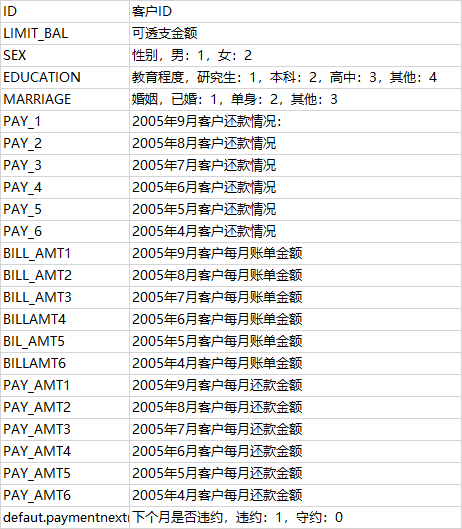

在原始训练集中存在结果，显然，这是一个监督式的机器学习，可供选择的特征有：
1. 信用卡额度，即可透支金额
2. 性别
3. 教育程度
4. 婚姻状况
5. 历史还款情况
6. 每月还款金额

最终的结果为是否违约，1代表违约，0代表不违约。

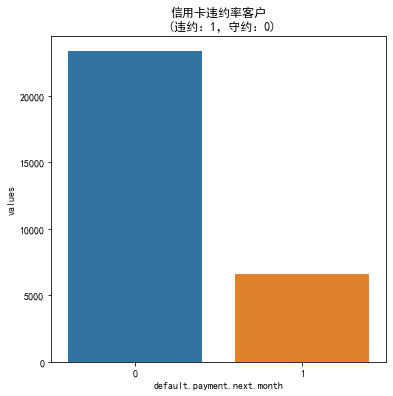

In [23]:
# 查看违约率情况
import matplotlib.pyplot as plt
import seaborn as sns
next_month = df['default.payment.next.month'].value_counts()
df1 = pd.DataFrame({'default.payment.next.month':next_month.index,'values':next_month.values})
plt.rcParams['font.sans-serif']=['SimHei'] # 用来正常显示中文标签
plt.figure(figsize = (6,6))
plt.title('信用卡违约率客户\n (违约：1，守约：0)')
sns.set_color_codes("pastel")
sns.barplot(x = 'default.payment.next.month', y="values", data=df1)
locs, labels = plt.xticks()
plt.show()

In [96]:
from sklearn.model_selection import learning_curve, train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# 划分训练集及特征选择
#df.drop(['ID'], inplace=True, axis =1) #ID 这个字段没有用
target = df['default.payment.next.month']      # 目标值
columns = df.columns.tolist()                  # 所有的列索引放在一个列表里
columns.remove('default.payment.next.month')       # 删掉列表里面的目标索引
features = df[columns]                   # 所有的特征值

train_x, test_x, train_y, test_y = train_test_split(features, target, test_size=0.30, stratify = target)


# 构造随机森林
RF = RandomForestClassifier()

# 进行参数调优

#构造GirdSearchCV模块参数n_estimators范围为1-11,max_depth为1-5
params = {'randomforestclassifier__n_estimators':range(1,20),
         'randomforestclassifier__max_depth':range(1,25),
         }

pipelines = Pipeline(
                    [('scaler',StandardScaler()),
                    ('randomforestclassifier',RF)]
                    )
#进行参数调优
clfs = GridSearchCV(estimator=pipelines,param_grid=params,cv=4)

clfs.fit(train_x,train_y)

print('最优成绩:%.4lf'%clfs.best_score_)
print('最优参数:%s'%clfs.best_params_)  

最优成绩:0.8201
最优参数:{'randomforestclassifier__max_depth': 7, 'randomforestclassifier__n_estimators': 14}


In [99]:
from sklearn import metrics #评估模型的指标库
#将参数应用于数据
# 构造随机森林
RF = RandomForestClassifier(n_estimators=6,max_depth=5)
RF.fit(train_x,train_y)
res = RF.predict(test_x)

#模型的准确率
print("测试集准确度",metrics.accuracy_score(test_y,res))

测试集准确度 0.8133333333333334


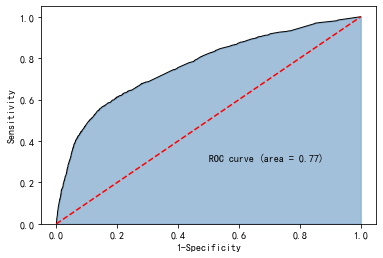

In [100]:
# 绘制ROC曲线
import matplotlib.pyplot as plt
y_score = RF.predict_proba(test_x)[:,1]
fpr,tpr,threshold = metrics.roc_curve(test_y, y_score)
# 计算AUC的值
roc_auc = metrics.auc(fpr,tpr)

# 绘制面积图
plt.stackplot(fpr, tpr, color='steelblue', alpha = 0.5, edgecolor = 'black')
# 添加边际线
plt.plot(fpr, tpr, color='black', lw = 1)
# 添加对角线
plt.plot([0,1],[0,1], color = 'red', linestyle = '--')
# 添加文本信息
plt.text(0.5,0.3,'ROC curve (area = %0.2f)' % roc_auc)
# 添加x轴与y轴标签
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
# 显示图形
plt.show()

ROC的全称是Receiver Operating Characteristic Curve，中文名字叫“受试者工作特征曲线”，顾名思义，其主要的分析方法就是画这条特征曲线。


[ROC曲线](https://www.jianshu.com/p/2ca96fce7e81)

源数据集：https://github.com/cystanford/credit_default

第一次计算：
最优成绩:0.8181
最优参数:{'randomforestclassifier__max_depth': 6, 'randomforestclassifier__n_estimators': 5}
最后的auc值为0.77，不是很好，还有优化的空间，这里重新调整下参数范围，选取最合适参数。

第二次计算：
最优成绩:0.8204
最优参数:{'randomforestclassifier__max_depth': 10, 'randomforestclassifier__n_estimators': 19}
最后的auc值为0.74，不是很好，还有优化的空间，这里重新调整下参数范围，选取最合适参数。

第三次计算：
最优成绩:0.8201
最优参数:{'randomforestclassifier__max_depth': 7, 'randomforestclassifier__n_estimators': 14}
最后的auc值为0.75，

所以，还是使用第一次的参数吧
最优参数:{'randomforestclassifier__max_depth': 6, 'randomforestclassifier__n_estimators': 5}
最后的auc值为0.77